In [47]:
import pandas as pd
from module.function import *
from module.learning import *

In [48]:
from Crawl import *

In [49]:
coin_list = 'TRX,NEO,BLZ,ICX,EOS,VEN,XRP,ADA,XLM,FUN,BNB,DGD,LTC,IOTA,CTR,WTC,CND,QSP,OMG,PPT,ZRX,IOST,GXS,XVG,BQX,LSK,REQ,POWR,POE,ELF,QTUM,ENG,BTS,AION,XMR,VIBE,SNT,KNC,ETC,MANA,VIB,LEND,SUB,OST,SALT,ZEC,ENJ,NEBL,HSR,NULS,LINK,BCD,LRC,WABI,TNB,GTO,ARK,TRIG,DASH,APPC,STRAT,MTL,SNGLS,MDA,INS,GVT,TNT,AST,BAT,BTG,MCO,CDT,LUN,ARN,AMB,WAVES,ADX,FUEL,BRD,RCN,XZC,MOD,NAV,EVX,DNT,KMD,BNT,ICN,BCPT,STORJ,DLT,EDO,WINGS,SNM,MTH,OAX,YOYO'.split(',')

In [50]:
a = pd.read_csv('data_csv/data_ADA_KRW.csv').drop(['Unnamed: 0'], axis = 1)
b = a

In [51]:
#a['high-low'] = a.high - a.low

In [52]:
#a['open-close'] = a.open - a.close

In [53]:
close = np.array(a.close)
volume = np.array(a.volumeto)
print(close.shape)

(501,)


In [54]:
price_del = [(close[i+1]-close[i])/close[i] for i in range(len(close)-1)] + [None]

In [55]:
volume_del = [(volume[i+1]-volume[i])/volume[i] for i in range(len(close)-1)] + [None]

In [56]:
a['p_del'] = price_del
a['v_del'] = volume_del

In [57]:
a = a[['p_del', 'v_del']]
#a['open-close'] = a['open-close']
#a['high-low'] = a['high-low']

making label

In [58]:
label = []
for i in range(500):
    if (b.close[i+1] - b.close[i])/b.close[i] < -0:
        label.append([1,0])
    elif (b.close[i+1] - b.close[i])/b.close[i] > 0:
        label.append([0,1])
t_tr = np.array(label)

In [59]:
x_tr = np.array(a)

In [74]:
iters_num = 10000
train_size = 486
batch_size = 243
learning_rate = 0.1

In [75]:
net = Learning(insize = 2, hidsize = 100, outsize = 2)

In [76]:
now = time.time()
train_loss = []
moment = Momentum()
#moment = Momentum()
for i in range(iters_num):
    slicing = np.random.choice(train_size, batch_size)
    x_batch = x_tr[slicing]
    t_batch = t_tr[slicing]
    
    gradient = net.grad_back(x_batch, t_batch)
    
    
    moment.update(net.params, gradient)
        
    loss = net.loss(x_batch, t_batch)
    train_loss.append(loss)
    
    elapsed_time = (time.time()-now)
    second = elapsed_time%60
    minute = elapsed_time//60%60
    hour = elapsed_time//3600
    
    print('calc {0:.2f}% done. elapsed : {1:.0f}h {2:.0f}m {3:.0f}s'.format((i+1)*100/iters_num,hour, minute, second), end = '\r')


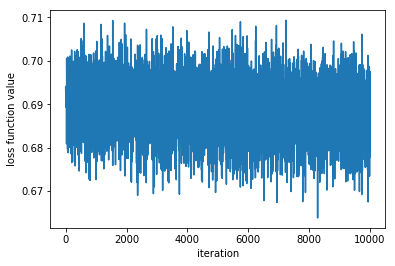

In [77]:
plt.plot(range(iters_num), train_loss)
plt.xlabel('iteration')
plt.ylabel('loss function value')
plt.show()

In [38]:
train_loss[400]

0.6762051700036635